In [41]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import random 
import numpy as np
import torch
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)
set_seed(42)

In [42]:
from sentence_transformers import SentenceTransformer 
import torch
import torch.nn as nn


In [43]:
sentences = ['That is a happy person', 'That is a very happy person', 'That is a sad person', 'My drawing was not a picture of a hat']
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
model_embedding = SentenceTransformer('thenlper/gte-small',device=device)
embeddings =model_embedding.encode(sentences,convert_to_tensor=True)
print(f"embeddings.shape = {embeddings.shape}")
print(f"embeddings[0][:3] = {embeddings[0][:3]}")
cos = nn.CosineSimilarity(dim=0)

print(f"Cosine similarity between '{sentences[0]}' and '{sentences[1]}' is {cos(embeddings[0], embeddings[1]).item():.3f}")
print(f"Cosine similarity between '{sentences[0]}' and '{sentences[2]}' is {cos(embeddings[0], embeddings[2]).item():.3f}")
print(f"Cosine similarity between '{sentences[0]}' and '{sentences[3]}' is {cos(embeddings[0], embeddings[3]).item():.3f}")

Using cuda:0
embeddings.shape = torch.Size([4, 384])
embeddings[0][:3] = tensor([-0.0532,  0.0104,  0.0619], device='cuda:0')
Cosine similarity between 'That is a happy person' and 'That is a very happy person' is 0.982
Cosine similarity between 'That is a happy person' and 'That is a sad person' is 0.898
Cosine similarity between 'That is a happy person' and 'My drawing was not a picture of a hat' is 0.752


In [44]:
sentences_train = [
    # politics:
    'The election results were surprising',
    'The new policy on healthcare was announced',
    'The government passed a new education reform',
    # sports:
    'The soccer team won the championship',
    'The Olympics will be held next year',
    'She won the gold medal in swimming',
    # culture:
    'The museum exhibited contemporary art',
    'The film festival was a huge success',
    'The concert was sold out'
]

labels_train = [0, 0, 0, 1, 1, 1, 2, 2, 2]  # 0: politics, 1: sports, 2: culture

sentences_test = [
    'A new law was proposed',
    'The basketball game was exciting',
    'The opera was a beautiful experience'
]

labels_test = [0, 1, 2]

In [45]:
embeddings_train = model_embedding.encode(sentences_train,convert_to_tensor=True)
embeddings_test = model_embedding.encode(sentences_test,convert_to_tensor=True)

embeddings_train = embeddings_train.clone().detach().to(device)
embeddings_test  = embeddings_test.clone().detach().to(device)

labels_train = torch.tensor(labels_train).to(device)
labels_test = torch.tensor(labels_test).to(device)

print(f"type(embeddings_train)  = {type(embeddings_train)}")
print(f"embeddings_train.shape = {embeddings_train.shape}")
print(f"embeddings_train[0][:3] = {embeddings_train[0][:3]}")


type(embeddings_train)  = <class 'torch.Tensor'>
embeddings_train.shape = torch.Size([9, 384])
embeddings_train[0][:3] = tensor([-0.0382,  0.0470,  0.0139], device='cuda:0')


In [46]:
import torch.nn.functional as F
class SoftmaxRegressor(nn.Module):
    def __init__(self,input_size,num_classes):
        super(SoftmaxRegressor,self).__init__()
        self.linear=nn.Linear(input_size,num_classes)
    def forward(self,x):
        return F.log_softmax(self.linear(x),dim=1)


In [47]:
input_size = embeddings_train.size(1)
num_classes = 3
learning_rate = 0.005

model=SoftmaxRegressor(input_size,num_classes)
model.to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)


Step [0/10000],  loss =  0.4111
Step [1000/10000],  loss =  0.3813
Step [2000/10000],  loss =  0.3549
Step [3000/10000],  loss =  0.3314
Step [4000/10000],  loss =  0.3105
Step [5000/10000],  loss =  0.2917
Step [6000/10000],  loss =  0.2748
Step [7000/10000],  loss =  0.2596
Step [8000/10000],  loss =  0.2458
Step [9000/10000],  loss =  0.2332
Step [10000/10000],  loss =  0.2217


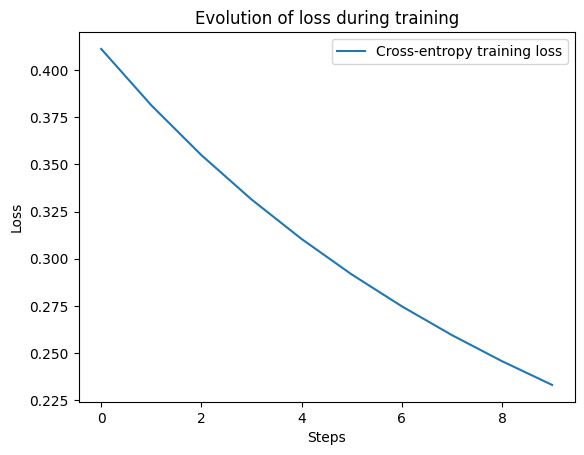

In [49]:
training_steps = 10000
eval_steps = 1000
model.train()
losses = []
for i in range(training_steps):
    outputs = model(embeddings_train)
    loss = criterion(outputs,labels_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    if(i%eval_steps==0):
        print(f"Step [{i}/{training_steps}],  loss =  {loss.item():.4f}")
        losses.append(loss.item())

print(f"Step [{training_steps}/{training_steps}],  loss =  {loss.item():.4f}")

import matplotlib.pyplot as plt

plt.plot(losses,label = 'Cross-entropy training loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Evolution of loss during training")
plt.legend()
plt.show()

In [50]:
model.eval()
with torch.no_grad():
    correct=0
    total =len(embeddings_test)
    labels = model(embeddings_test)
    print(f"labels = {labels}")
    _,prediction = torch.max(labels,dim=1)
    print(f"prediction = {prediction}")
    correct+= (labels_test==prediction).type(torch.float).sum().item()
    accuracy = 100*correct/total
    print(f"Accuracy on test data: {accuracy:.2f}")

labels = tensor([[-0.4976, -1.4633, -1.8290],
        [-1.3603, -0.7634, -1.2826],
        [-1.7001, -1.5467, -0.5036]], device='cuda:0')
prediction = tensor([0, 1, 2], device='cuda:0')
Accuracy on test data: 100.00


In [51]:
torch.save(model.state_dict(),'model.pth')
loaded_model = SoftmaxRegressor(input_size,num_classes)
loaded_model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>